<a href="https://colab.research.google.com/github/tsmanral/Author-Prediction-Using-Deep-Learning-Models/blob/master/Model_for_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D
from keras.layers import Flatten, GlobalAveragePooling1D
from keras.layers import Embedding, TimeDistributed, MaxPooling1D
import keras.utils
from keras.callbacks import ModelCheckpoint  


Using TensorFlow backend.


In [0]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data_clean')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1W_ncgu50M_LR65A4jVvCuFklmosjIfpz' in parents"}).GetList()

data = []
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  with open(fname, 'r', encoding = "ISO-8859-1") as file:
    data.append([f['title'].split('-')[0], file.read()])

title: Humphrey Ward - 14.txt, id: 1KQ8TIQFtWWWJhsp6QIpn5RGhYO7NQ3wk
downloading to /content/data_clean/Humphrey Ward - 14.txt
title: Humphrey Ward - 16.txt, id: 1Xx6zE79WHWVFowU477l1YPGYMnEd4uCn
downloading to /content/data_clean/Humphrey Ward - 16.txt
title: Humphrey Ward - 19.txt, id: 1T9QE_hSZUx17oa7QGekYM23SIgLSfsE4
downloading to /content/data_clean/Humphrey Ward - 19.txt
title: Humphrey Ward - 17.txt, id: 1xx-umzzZFNncv9X8OWWj4auY60ShAE-8
downloading to /content/data_clean/Humphrey Ward - 17.txt
title: Humphrey Ward - 15.txt, id: 1CsLYGbi6pirecPBPNwli90Sb-XSM8q33
downloading to /content/data_clean/Humphrey Ward - 15.txt
title: Humphrey Ward - 18.txt, id: 1EULi5tNbF07SbrhycdDj_u58MVe8te2N
downloading to /content/data_clean/Humphrey Ward - 18.txt
title: Humphrey Ward - 13.txt, id: 15za4_hyAnLyw9xALmmp3R54m-ZfGtnjv
downloading to /content/data_clean/Humphrey Ward - 13.txt
title: Humphrey Ward - 9.txt, id: 1ZwNeiFvLOHUXsAJHUvC2PIJupsxT89Ne
downloading to /content/data_clean/Humphrey

title: Henry Rider Haggard - 2.txt, id: 182DLelFZVUwgVCXgMYqyljcdeVekKLyg
downloading to /content/data_clean/Henry Rider Haggard - 2.txt
title: Henry Rider Haggard - 4.txt, id: 1RW0VikO9suP-fdX6U9WlmPnC47Pw_gTV
downloading to /content/data_clean/Henry Rider Haggard - 4.txt
title: Gilbert Parker - 14.txt, id: 1PtwJLsc_phb72-juruLNQWBWJgzbY2gk
downloading to /content/data_clean/Gilbert Parker - 14.txt
title: Henry Rider Haggard - 6.txt, id: 103UEqkdS8kQsRH9WWQqY2I3jM0pwHRj1
downloading to /content/data_clean/Henry Rider Haggard - 6.txt
title: Henry Rider Haggard - 1.txt, id: 1kxRrRkIluKMT-OZLdo6vqoWiUcGX23qN
downloading to /content/data_clean/Henry Rider Haggard - 1.txt
title: Gilbert Parker - 16.txt, id: 17na4xSvHKXD5OmCeJYiHVyf3YWnONGNs
downloading to /content/data_clean/Gilbert Parker - 16.txt
title: Henry Rider Haggard - 3.txt, id: 10P8MfJtE9KcHf9DwutglKBuSFVbi3GTx
downloading to /content/data_clean/Henry Rider Haggard - 3.txt
title: Gilbert Parker - 15.txt, id: 1RsBp3uXa_WruUJeYPAP0

title: George Gissing - 2.txt, id: 1TgeehcW7iqntOfbRLH8iy1I15XBVdaxj
downloading to /content/data_clean/George Gissing - 2.txt
title: George Gissing - 1.txt, id: 1KDkLX5NHiTSltmuM62AjHLvysn9YIOsr
downloading to /content/data_clean/George Gissing - 1.txt
title: Arthur Conan Doyle - 16.txt, id: 1x7aFEQd4B22hXRhgcXtFqpFynrELXh_1
downloading to /content/data_clean/Arthur Conan Doyle - 16.txt
title: Arthur Conan Doyle - 11.txt, id: 1r5sFr40dIr6fRkcxLSKnGFGAAAA6S5pT
downloading to /content/data_clean/Arthur Conan Doyle - 11.txt
title: Arthur Conan Doyle - 14.txt, id: 1Il1phCs0DRuvcGPWCeTBZxBhyrzuNvJd
downloading to /content/data_clean/Arthur Conan Doyle - 14.txt
title: Arthur Conan Doyle - 17.txt, id: 1WO8c4eGI0PrkbgPKuycecVefuVn8PRfK
downloading to /content/data_clean/Arthur Conan Doyle - 17.txt
title: Arthur Conan Doyle - 13.txt, id: 1FePgEn_ZEgdeqWtdJyI5PNR8RXAlSCas
downloading to /content/data_clean/Arthur Conan Doyle - 13.txt
title: Arthur Conan Doyle - 12.txt, id: 1BU0YcOr-_2EbjkxSrPuw

In [0]:
X = []
for _,c in data:
    X.append(c.lower())
    
Y = []
for i,_ in data:
    Y.append(i.lower())

X1 = []
Y_data1 = []

for text in X:
  c = text.strip().split()
  X1.append(c)

print(len(X))
X_data1 = []
count = 0
for i in X1:
  m=0
  n=1000
  times = len(i)//1000
  for j in range(times):
    X_data1.append(i[m:n])
    m = m + 1000
    n = n + 1000
    Y_data1.append(Y[count]) 
  X_data1.append(i[m:len(i)+1])
  Y_data1.append(Y[count])
  count = count + 1 



98


In [0]:
temp_list = []
for i in range(len(X_data1)):
  temp_list.append([X_data1[i], Y_data1[i]])
print(len(temp_list))
print(temp_list[0][1])

import random

random.shuffle(temp_list)
print(len(temp_list))
print(temp_list[0][1])

X_data = []
Y_data = []
for i in range(len(temp_list)):
  X_data.append(temp_list[i][0])
  Y_data.append(temp_list[i][1])
print(len(X_data), len(Y_data))
print(X_data[0], Y_data[0])

10078
humphrey ward 
10078
george gissing 
10078 10078
['to', 'a', 'pitying', 'shrug', 'of', 'the', 'shoulders', 'but', 'he', 'could', 'not', 'speak', 'otherwise', 'than', 'vigorously', 'and', 'at', 'times', 'his', 'words', 'were', 'eloquent', 'we', 'know', 'not', 'how', 'things', 'may', 'improve', 'in', 'the', 'future', 'thus', 'he', 'perorated', 'but', 'let', 'celibate', 'ladies', 'of', 'the', 'present', 'bear', 'in', 'mind', 'that', 'the', 'chances', 'are', 'enormously', 'against', 'their', 'making', 'a', 'marriage', 'worthy', 'of', 'the', 'name', 'oh', 'from', 'some', 'man', 'at', 'the', 'back', 'let', 'them', 'remember', 'too', 'if', 'they', 'are', 'disposed', 'to', 'altruism', 'that', 'though', 'most', 'men', 'manage', 'to', 'find', 'a', 'wife', 'very', 'few', 'indeed', 'as', 'things', 'are', 'do', 'not', 'ultimately', 'wish', 'that', 'they', 'had', 'remained', 'single', 'a', 'roar', 'of', 'laughter', 'and', 'many', 'protests', 'this', 'being', 'so', 'let', 'women', 'who', 'have'

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Converting Output values to One Hot Vector
print("Converting to One hot vector(training set)...")
Y_data = np.array(Y_data)
#print(train_values)

label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(Y_data)
print(train_integer_encoded)


Converting to One hot vector(training set)...
[1 1 3 ... 4 1 0]


In [0]:
train_onehot_encoded = keras.utils.to_categorical(train_integer_encoded)
print(train_onehot_encoded[2841,:])

[0. 0. 0. 1. 0.]


In [0]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
print(vocab_size)

128625


In [0]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_data)
print(encoded_docs[0])

[4, 5, 10819, 4993, 3, 1, 680, 21, 8, 55, 22, 235, 1206, 81, 7120, 2, 20, 439, 14, 207, 39, 5897, 45, 72, 22, 88, 157, 129, 7926, 7, 1, 735, 390, 8, 57481, 21, 149, 37749, 997, 3, 1, 417, 545, 7, 150, 10, 1, 2206, 58, 7069, 182, 61, 475, 5, 535, 1477, 3, 1, 259, 172, 32, 67, 60, 20, 1, 100, 149, 49, 352, 139, 46, 35, 58, 2884, 4, 17954, 10, 128, 177, 136, 2273, 4, 227, 5, 247, 66, 187, 196, 19, 157, 58, 57, 22, 4934, 301, 10, 35, 16, 675, 1148, 5, 2251, 3, 1291, 2, 168, 10820, 33, 238, 37, 149, 299, 44, 26, 38, 584, 3, 61, 105, 5951, 410, 2009, 402, 4, 1, 2734, 2, 364, 1405, 3, 3256, 1, 228, 2998, 2971, 37, 10, 35, 129, 286, 4, 22556, 42, 3, 1, 2239, 11141, 3, 9195, 1533, 2, 4025, 18, 299, 3, 1, 735, 1, 2274, 3, 5, 109, 1805, 11337, 3600, 239, 85, 17, 5, 2197, 3, 18569, 1659, 14, 3861, 9, 5, 1182, 22, 5, 338, 3, 11, 8, 138, 1, 6088, 1052, 2, 185, 1337, 5584, 3257, 30, 7927, 1887, 17, 14, 105, 331, 2, 1524, 5, 4337, 3, 1925, 9, 238, 2391, 53, 329, 44245, 8, 9, 961, 3, 67, 57482, 7, 1, 4

In [0]:
# pad documents to a max length of 10000 words
max_length = 1000
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[    4     5 10819 ...   204     4   218]
 [   25  2662    21 ...  5138  2096    18]
 [   64  2874   294 ...     2  4133    82]
 ...
 [   40   952    28 ...    40    64   939]
 [11138    97     1 ...   424    53     8]
 [  328    28   671 ...    77   536    51]]


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1ogZLyJ5GTI8a0o8HPac8zTtm96SzCv-k' in parents"}).GetList()
print(file_list[0]['title'], file_list[0]['id'] )
fname = os.path.join(local_download_path, file_list[0]['title'])
f_ = drive.CreateFile({'id': file_list[0]['id']})
f_.GetContentFile(fname)


# load the whole embedding into memory
embeddings_index = dict()
f = open(fname)
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

glove.6B.100d.txt 17BmrNJa4oJDNg3KZ6u2Ww0ETQYklOJJ7
Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(128625, 100)


In [0]:
print(padded_docs.shape)
doc_train = np.array(padded_docs[0:8000,:])
print(doc_train.shape)
doc_test = np.array(padded_docs[8000:,:])
print(doc_test.shape)

onehot_train = np.array(train_onehot_encoded[0:8000,:])
print(onehot_train.shape)
onehot_test = np.array(train_onehot_encoded[8000:,:])
print(onehot_test.shape)

(10078, 1000)
(8000, 1000)
(2078, 1000)
(8000, 5)
(2078, 5)


In [0]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1000, trainable=False)
model.add(e)
model.add(Conv1D(16, 3, border_mode='valid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 3, border_mode='valid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, border_mode='valid'))
model.add(MaxPooling1D(pool_size=2))

model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))

model.add(Dense(3000, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.3))

#model.add(Dense(30000, activation='relu'))
#model.add(Dropout(0.6))

model.add(Dense(5, activation='softmax'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(16, 3, padding="valid")`
  after removing the cwd from sys.path.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, 3, padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, padding="valid")`
  


In [0]:
# compile the model
num_of_epochs = 500
batchsize = 2000
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         12862500  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 998, 16)           4816      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 499, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 497, 32)           1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 248, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 246, 64)           6208      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 123, 64)           0         
__________

In [0]:
checkpointer = ModelCheckpoint(filepath='/content/weights.best.CNN_pos.hdf5', 
                               verbose=1, save_best_only=True)

In [0]:
# fit the model
history = model.fit(doc_train, onehot_train, epochs=num_of_epochs, verbose=1, batch_size=batchsize, callbacks=[checkpointer], validation_split=0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/500
6400/6400 [==============================] - 2s 308us/step - loss: 3.1059 - categorical_accuracy: 0.5697 - val_loss: 1.2637 - val_categorical_accuracy: 0.5756

Epoch 00001: val_loss improved from inf to 1.26374, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 2/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.8311 - categorical_accuracy: 0.6984 - val_loss: 0.4700 - val_categorical_accuracy: 0.8425

Epoch 00002: val_loss improved from 1.26374 to 0.47003, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 3/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4244 - categorical_accuracy: 0.8608 - val_loss: 0.4561 - val_categorical_accuracy: 0.8419

Epoch 00003: val_loss improved from 0.47003 to 0.45611, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 4/500
6400/6400 [==============================] - 1s 153us/step - loss: 0.4103 - categorical_accuracy: 0.8603 - 

6400/6400 [==============================] - 1s 156us/step - loss: 0.4838 - categorical_accuracy: 0.8219 - val_loss: 0.4884 - val_categorical_accuracy: 0.8219

Epoch 00013: val_loss did not improve
Epoch 14/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5573 - categorical_accuracy: 0.7950 - val_loss: 1.2228 - val_categorical_accuracy: 0.6081

Epoch 00014: val_loss did not improve
Epoch 15/500
6400/6400 [==============================] - 1s 157us/step - loss: 1.0055 - categorical_accuracy: 0.6603 - val_loss: 0.5494 - val_categorical_accuracy: 0.7850

Epoch 00015: val_loss did not improve
Epoch 16/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4739 - categorical_accuracy: 0.8322 - val_loss: 0.6431 - val_categorical_accuracy: 0.7569

Epoch 00016: val_loss did not improve
Epoch 17/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.6039 - categorical_accuracy: 0.7653 - val_loss: 0.6353 - val_categorical_accuracy: 0.76

6400/6400 [==============================] - 1s 158us/step - loss: 0.5821 - categorical_accuracy: 0.7820 - val_loss: 0.4742 - val_categorical_accuracy: 0.8294

Epoch 00026: val_loss did not improve
Epoch 27/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4530 - categorical_accuracy: 0.8417 - val_loss: 0.5358 - val_categorical_accuracy: 0.7994

Epoch 00027: val_loss did not improve
Epoch 28/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.4896 - categorical_accuracy: 0.8188 - val_loss: 0.5099 - val_categorical_accuracy: 0.8144

Epoch 00028: val_loss did not improve
Epoch 29/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5730 - categorical_accuracy: 0.7828 - val_loss: 0.6377 - val_categorical_accuracy: 0.7600

Epoch 00029: val_loss did not improve
Epoch 30/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4846 - categorical_accuracy: 0.8272 - val_loss: 0.6838 - val_categorical_accuracy: 0.75

6400/6400 [==============================] - 1s 159us/step - loss: 0.5944 - categorical_accuracy: 0.7761 - val_loss: 0.8460 - val_categorical_accuracy: 0.6913

Epoch 00039: val_loss did not improve
Epoch 40/500
6400/6400 [==============================] - 1s 159us/step - loss: 0.6667 - categorical_accuracy: 0.7616 - val_loss: 0.5556 - val_categorical_accuracy: 0.7812

Epoch 00040: val_loss did not improve
Epoch 41/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4673 - categorical_accuracy: 0.8278 - val_loss: 0.5817 - val_categorical_accuracy: 0.7550

Epoch 00041: val_loss did not improve
Epoch 42/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4944 - categorical_accuracy: 0.8100 - val_loss: 0.4271 - val_categorical_accuracy: 0.8512

Epoch 00042: val_loss improved from 0.44155 to 0.42712, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 43/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4869 - categorical

6400/6400 [==============================] - 1s 156us/step - loss: 0.3776 - categorical_accuracy: 0.8684 - val_loss: 0.5307 - val_categorical_accuracy: 0.8006

Epoch 00052: val_loss did not improve
Epoch 53/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.6825 - categorical_accuracy: 0.7478 - val_loss: 0.6700 - val_categorical_accuracy: 0.7437

Epoch 00053: val_loss did not improve
Epoch 54/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5516 - categorical_accuracy: 0.7942 - val_loss: 0.5564 - val_categorical_accuracy: 0.7919

Epoch 00054: val_loss did not improve
Epoch 55/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.6175 - categorical_accuracy: 0.7766 - val_loss: 0.7745 - val_categorical_accuracy: 0.7113

Epoch 00055: val_loss did not improve
Epoch 56/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.6973 - categorical_accuracy: 0.7320 - val_loss: 0.4324 - val_categorical_accuracy: 0.85

6400/6400 [==============================] - 1s 157us/step - loss: 0.5653 - categorical_accuracy: 0.7792 - val_loss: 0.5058 - val_categorical_accuracy: 0.8144

Epoch 00065: val_loss did not improve
Epoch 66/500
6400/6400 [==============================] - 1s 159us/step - loss: 0.4505 - categorical_accuracy: 0.8303 - val_loss: 0.5558 - val_categorical_accuracy: 0.7781

Epoch 00066: val_loss did not improve
Epoch 67/500
6400/6400 [==============================] - 1s 159us/step - loss: 0.5775 - categorical_accuracy: 0.7803 - val_loss: 0.7039 - val_categorical_accuracy: 0.7262

Epoch 00067: val_loss did not improve
Epoch 68/500
6400/6400 [==============================] - 1s 160us/step - loss: 0.5889 - categorical_accuracy: 0.7700 - val_loss: 0.6085 - val_categorical_accuracy: 0.7763

Epoch 00068: val_loss did not improve
Epoch 69/500
6400/6400 [==============================] - 1s 159us/step - loss: 0.6048 - categorical_accuracy: 0.7873 - val_loss: 1.0996 - val_categorical_accuracy: 0.60

6400/6400 [==============================] - 1s 156us/step - loss: 0.5523 - categorical_accuracy: 0.7983 - val_loss: 0.6013 - val_categorical_accuracy: 0.7644

Epoch 00078: val_loss did not improve
Epoch 79/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5573 - categorical_accuracy: 0.7838 - val_loss: 0.4528 - val_categorical_accuracy: 0.8475

Epoch 00079: val_loss did not improve
Epoch 80/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4431 - categorical_accuracy: 0.8420 - val_loss: 0.5298 - val_categorical_accuracy: 0.8025

Epoch 00080: val_loss did not improve
Epoch 81/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4807 - categorical_accuracy: 0.8231 - val_loss: 1.0101 - val_categorical_accuracy: 0.6594

Epoch 00081: val_loss did not improve
Epoch 82/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.8919 - categorical_accuracy: 0.6881 - val_loss: 0.4695 - val_categorical_accuracy: 0.83

6400/6400 [==============================] - 1s 157us/step - loss: 0.7026 - categorical_accuracy: 0.7338 - val_loss: 0.6453 - val_categorical_accuracy: 0.7312

Epoch 00091: val_loss did not improve
Epoch 92/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5815 - categorical_accuracy: 0.7780 - val_loss: 0.6337 - val_categorical_accuracy: 0.7581

Epoch 00092: val_loss did not improve
Epoch 93/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5300 - categorical_accuracy: 0.8098 - val_loss: 0.5476 - val_categorical_accuracy: 0.7937

Epoch 00093: val_loss did not improve
Epoch 94/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4582 - categorical_accuracy: 0.8378 - val_loss: 0.4892 - val_categorical_accuracy: 0.8112

Epoch 00094: val_loss did not improve
Epoch 95/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5409 - categorical_accuracy: 0.7958 - val_loss: 0.4578 - val_categorical_accuracy: 0.83

6400/6400 [==============================] - 1s 159us/step - loss: 0.5308 - categorical_accuracy: 0.7950 - val_loss: 0.3939 - val_categorical_accuracy: 0.8619

Epoch 00104: val_loss improved from 0.40435 to 0.39389, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 105/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3578 - categorical_accuracy: 0.8809 - val_loss: 0.4819 - val_categorical_accuracy: 0.8175

Epoch 00105: val_loss did not improve
Epoch 106/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.5078 - categorical_accuracy: 0.8044 - val_loss: 0.4544 - val_categorical_accuracy: 0.8344

Epoch 00106: val_loss did not improve
Epoch 107/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.6290 - categorical_accuracy: 0.7633 - val_loss: 0.6568 - val_categorical_accuracy: 0.7531

Epoch 00107: val_loss did not improve
Epoch 108/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.6249 - categor


Epoch 00116: val_loss did not improve
Epoch 117/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.5063 - categorical_accuracy: 0.8102 - val_loss: 0.6702 - val_categorical_accuracy: 0.7644

Epoch 00117: val_loss did not improve
Epoch 118/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5857 - categorical_accuracy: 0.7866 - val_loss: 0.5120 - val_categorical_accuracy: 0.8238

Epoch 00118: val_loss did not improve
Epoch 119/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4615 - categorical_accuracy: 0.8291 - val_loss: 0.5641 - val_categorical_accuracy: 0.7912

Epoch 00119: val_loss did not improve
Epoch 120/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4604 - categorical_accuracy: 0.8289 - val_loss: 0.5583 - val_categorical_accuracy: 0.7887

Epoch 00120: val_loss did not improve
Epoch 121/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4638 - categorical_accuracy: 0

6400/6400 [==============================] - 1s 160us/step - loss: 0.4323 - categorical_accuracy: 0.8441 - val_loss: 0.4224 - val_categorical_accuracy: 0.8438

Epoch 00130: val_loss did not improve
Epoch 131/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.3715 - categorical_accuracy: 0.8680 - val_loss: 0.4081 - val_categorical_accuracy: 0.8581

Epoch 00131: val_loss did not improve
Epoch 132/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.5731 - categorical_accuracy: 0.7833 - val_loss: 0.8019 - val_categorical_accuracy: 0.7106

Epoch 00132: val_loss did not improve
Epoch 133/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.8612 - categorical_accuracy: 0.6712 - val_loss: 0.5818 - val_categorical_accuracy: 0.7837

Epoch 00133: val_loss did not improve
Epoch 134/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4361 - categorical_accuracy: 0.8450 - val_loss: 0.4025 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 158us/step - loss: 0.7032 - categorical_accuracy: 0.7494 - val_loss: 0.6721 - val_categorical_accuracy: 0.7437

Epoch 00143: val_loss did not improve
Epoch 144/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.5832 - categorical_accuracy: 0.7831 - val_loss: 0.3703 - val_categorical_accuracy: 0.8694

Epoch 00144: val_loss improved from 0.39389 to 0.37028, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 145/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3184 - categorical_accuracy: 0.8969 - val_loss: 0.3782 - val_categorical_accuracy: 0.8625

Epoch 00145: val_loss did not improve
Epoch 146/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.4451 - categorical_accuracy: 0.8381 - val_loss: 0.4640 - val_categorical_accuracy: 0.8219

Epoch 00146: val_loss did not improve
Epoch 147/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4493 - categor


Epoch 00155: val_loss did not improve
Epoch 156/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.6185 - categorical_accuracy: 0.7841 - val_loss: 0.4191 - val_categorical_accuracy: 0.8519

Epoch 00156: val_loss did not improve
Epoch 157/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3945 - categorical_accuracy: 0.8520 - val_loss: 0.5723 - val_categorical_accuracy: 0.7875

Epoch 00157: val_loss did not improve
Epoch 158/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.6467 - categorical_accuracy: 0.7520 - val_loss: 0.6602 - val_categorical_accuracy: 0.7600

Epoch 00158: val_loss did not improve
Epoch 159/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4589 - categorical_accuracy: 0.8387 - val_loss: 0.4265 - val_categorical_accuracy: 0.8413

Epoch 00159: val_loss did not improve
Epoch 160/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5265 - categorical_accuracy: 0

6400/6400 [==============================] - 1s 157us/step - loss: 0.5893 - categorical_accuracy: 0.7812 - val_loss: 0.5576 - val_categorical_accuracy: 0.7856

Epoch 00169: val_loss did not improve
Epoch 170/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.4947 - categorical_accuracy: 0.8141 - val_loss: 0.5412 - val_categorical_accuracy: 0.7975

Epoch 00170: val_loss did not improve
Epoch 171/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4596 - categorical_accuracy: 0.8294 - val_loss: 0.4061 - val_categorical_accuracy: 0.8494

Epoch 00171: val_loss did not improve
Epoch 172/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4621 - categorical_accuracy: 0.8331 - val_loss: 0.5860 - val_categorical_accuracy: 0.7763

Epoch 00172: val_loss did not improve
Epoch 173/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5304 - categorical_accuracy: 0.8142 - val_loss: 0.4738 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 157us/step - loss: 0.4335 - categorical_accuracy: 0.8455 - val_loss: 0.6695 - val_categorical_accuracy: 0.7494

Epoch 00182: val_loss did not improve
Epoch 183/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4555 - categorical_accuracy: 0.8373 - val_loss: 0.3505 - val_categorical_accuracy: 0.8725

Epoch 00183: val_loss did not improve
Epoch 184/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3109 - categorical_accuracy: 0.8941 - val_loss: 0.5330 - val_categorical_accuracy: 0.7925

Epoch 00184: val_loss did not improve
Epoch 185/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5876 - categorical_accuracy: 0.7730 - val_loss: 0.4857 - val_categorical_accuracy: 0.8112

Epoch 00185: val_loss did not improve
Epoch 186/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.6229 - categorical_accuracy: 0.7702 - val_loss: 0.4419 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 157us/step - loss: 0.3532 - categorical_accuracy: 0.8716 - val_loss: 0.5599 - val_categorical_accuracy: 0.7844

Epoch 00195: val_loss did not improve
Epoch 196/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4383 - categorical_accuracy: 0.8383 - val_loss: 0.4430 - val_categorical_accuracy: 0.8294

Epoch 00196: val_loss did not improve
Epoch 197/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5571 - categorical_accuracy: 0.7894 - val_loss: 0.6366 - val_categorical_accuracy: 0.7650

Epoch 00197: val_loss did not improve
Epoch 198/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.6033 - categorical_accuracy: 0.7802 - val_loss: 0.4859 - val_categorical_accuracy: 0.8087

Epoch 00198: val_loss did not improve
Epoch 199/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3920 - categorical_accuracy: 0.8566 - val_loss: 0.3721 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.3892 - categorical_accuracy: 0.8594 - val_loss: 0.4914 - val_categorical_accuracy: 0.8188

Epoch 00208: val_loss did not improve
Epoch 209/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4340 - categorical_accuracy: 0.8412 - val_loss: 0.5120 - val_categorical_accuracy: 0.8087

Epoch 00209: val_loss did not improve
Epoch 210/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4204 - categorical_accuracy: 0.8452 - val_loss: 0.4260 - val_categorical_accuracy: 0.8363

Epoch 00210: val_loss did not improve
Epoch 211/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5323 - categorical_accuracy: 0.7972 - val_loss: 0.6331 - val_categorical_accuracy: 0.7713

Epoch 00211: val_loss did not improve
Epoch 212/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5425 - categorical_accuracy: 0.8003 - val_loss: 0.4136 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.3217 - categorical_accuracy: 0.8850 - val_loss: 0.5433 - val_categorical_accuracy: 0.8012

Epoch 00221: val_loss did not improve
Epoch 222/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4895 - categorical_accuracy: 0.8159 - val_loss: 0.9048 - val_categorical_accuracy: 0.6994

Epoch 00222: val_loss did not improve
Epoch 223/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.8864 - categorical_accuracy: 0.7117 - val_loss: 0.4131 - val_categorical_accuracy: 0.8494

Epoch 00223: val_loss did not improve
Epoch 224/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3326 - categorical_accuracy: 0.8827 - val_loss: 0.4198 - val_categorical_accuracy: 0.8413

Epoch 00224: val_loss did not improve
Epoch 225/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.4117 - categorical_accuracy: 0.8423 - val_loss: 0.3378 - val_categorical_accuracy: 


Epoch 00233: val_loss did not improve
Epoch 234/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.6034 - categorical_accuracy: 0.7706 - val_loss: 0.5330 - val_categorical_accuracy: 0.7937

Epoch 00234: val_loss did not improve
Epoch 235/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4557 - categorical_accuracy: 0.8273 - val_loss: 0.4128 - val_categorical_accuracy: 0.8400

Epoch 00235: val_loss did not improve
Epoch 236/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3328 - categorical_accuracy: 0.8777 - val_loss: 0.4445 - val_categorical_accuracy: 0.8331

Epoch 00236: val_loss did not improve
Epoch 237/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3436 - categorical_accuracy: 0.8706 - val_loss: 0.8254 - val_categorical_accuracy: 0.7081

Epoch 00237: val_loss did not improve
Epoch 238/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.8044 - categorical_accuracy: 0

6400/6400 [==============================] - 1s 158us/step - loss: 0.3684 - categorical_accuracy: 0.8675 - val_loss: 0.7013 - val_categorical_accuracy: 0.7456

Epoch 00247: val_loss did not improve
Epoch 248/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.5849 - categorical_accuracy: 0.7769 - val_loss: 0.4487 - val_categorical_accuracy: 0.8325

Epoch 00248: val_loss did not improve
Epoch 249/500
6400/6400 [==============================] - 1s 160us/step - loss: 0.5367 - categorical_accuracy: 0.7973 - val_loss: 0.5083 - val_categorical_accuracy: 0.8156

Epoch 00249: val_loss did not improve
Epoch 250/500
6400/6400 [==============================] - 1s 161us/step - loss: 0.3867 - categorical_accuracy: 0.8634 - val_loss: 0.3709 - val_categorical_accuracy: 0.8694

Epoch 00250: val_loss did not improve
Epoch 251/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3245 - categorical_accuracy: 0.8845 - val_loss: 0.4423 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 157us/step - loss: 0.4094 - categorical_accuracy: 0.8431 - val_loss: 0.6295 - val_categorical_accuracy: 0.7731

Epoch 00260: val_loss did not improve
Epoch 261/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5527 - categorical_accuracy: 0.7950 - val_loss: 0.4296 - val_categorical_accuracy: 0.8331

Epoch 00261: val_loss did not improve
Epoch 262/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3090 - categorical_accuracy: 0.8898 - val_loss: 0.3505 - val_categorical_accuracy: 0.8694

Epoch 00262: val_loss did not improve
Epoch 263/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3767 - categorical_accuracy: 0.8641 - val_loss: 0.6438 - val_categorical_accuracy: 0.7638

Epoch 00263: val_loss did not improve
Epoch 264/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3920 - categorical_accuracy: 0.8598 - val_loss: 0.4633 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 157us/step - loss: 0.2860 - categorical_accuracy: 0.9014 - val_loss: 0.4526 - val_categorical_accuracy: 0.8338

Epoch 00273: val_loss did not improve
Epoch 274/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4580 - categorical_accuracy: 0.8342 - val_loss: 0.5297 - val_categorical_accuracy: 0.8069

Epoch 00274: val_loss did not improve
Epoch 275/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3747 - categorical_accuracy: 0.8636 - val_loss: 0.4081 - val_categorical_accuracy: 0.8450

Epoch 00275: val_loss did not improve
Epoch 276/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3963 - categorical_accuracy: 0.8511 - val_loss: 0.3352 - val_categorical_accuracy: 0.8819

Epoch 00276: val_loss did not improve
Epoch 277/500
6400/6400 [==============================] - 1s 155us/step - loss: 0.3232 - categorical_accuracy: 0.8806 - val_loss: 0.8363 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.3850 - categorical_accuracy: 0.8617 - val_loss: 0.3477 - val_categorical_accuracy: 0.8744

Epoch 00286: val_loss did not improve
Epoch 287/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2696 - categorical_accuracy: 0.9102 - val_loss: 0.3241 - val_categorical_accuracy: 0.8856

Epoch 00287: val_loss did not improve
Epoch 288/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3158 - categorical_accuracy: 0.8836 - val_loss: 0.5298 - val_categorical_accuracy: 0.8044

Epoch 00288: val_loss did not improve
Epoch 289/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.4491 - categorical_accuracy: 0.8264 - val_loss: 0.5672 - val_categorical_accuracy: 0.7962

Epoch 00289: val_loss did not improve
Epoch 290/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3428 - categorical_accuracy: 0.8811 - val_loss: 0.4892 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.7171 - categorical_accuracy: 0.7578 - val_loss: 0.5545 - val_categorical_accuracy: 0.7975

Epoch 00299: val_loss did not improve
Epoch 300/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3729 - categorical_accuracy: 0.8730 - val_loss: 0.4669 - val_categorical_accuracy: 0.8244

Epoch 00300: val_loss did not improve
Epoch 301/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.3545 - categorical_accuracy: 0.8686 - val_loss: 0.5401 - val_categorical_accuracy: 0.8031

Epoch 00301: val_loss did not improve
Epoch 302/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5305 - categorical_accuracy: 0.8103 - val_loss: 0.6046 - val_categorical_accuracy: 0.7763

Epoch 00302: val_loss did not improve
Epoch 303/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4301 - categorical_accuracy: 0.8448 - val_loss: 0.3428 - val_categorical_accuracy: 


Epoch 00311: val_loss did not improve
Epoch 312/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3007 - categorical_accuracy: 0.8856 - val_loss: 0.5292 - val_categorical_accuracy: 0.8019

Epoch 00312: val_loss did not improve
Epoch 313/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5636 - categorical_accuracy: 0.7869 - val_loss: 0.4504 - val_categorical_accuracy: 0.8344

Epoch 00313: val_loss did not improve
Epoch 314/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3208 - categorical_accuracy: 0.8839 - val_loss: 0.3632 - val_categorical_accuracy: 0.8600

Epoch 00314: val_loss did not improve
Epoch 315/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4197 - categorical_accuracy: 0.8447 - val_loss: 0.4680 - val_categorical_accuracy: 0.8281

Epoch 00315: val_loss did not improve
Epoch 316/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3950 - categorical_accuracy: 0

6400/6400 [==============================] - 1s 157us/step - loss: 0.3073 - categorical_accuracy: 0.8891 - val_loss: 0.4839 - val_categorical_accuracy: 0.8188

Epoch 00325: val_loss did not improve
Epoch 326/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4706 - categorical_accuracy: 0.8278 - val_loss: 0.3217 - val_categorical_accuracy: 0.8825

Epoch 00326: val_loss did not improve
Epoch 327/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.2487 - categorical_accuracy: 0.9148 - val_loss: 0.3623 - val_categorical_accuracy: 0.8556

Epoch 00327: val_loss did not improve
Epoch 328/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3474 - categorical_accuracy: 0.8706 - val_loss: 0.5033 - val_categorical_accuracy: 0.8094

Epoch 00328: val_loss did not improve
Epoch 329/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4958 - categorical_accuracy: 0.8231 - val_loss: 0.8631 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.2670 - categorical_accuracy: 0.9045 - val_loss: 0.5114 - val_categorical_accuracy: 0.8094

Epoch 00338: val_loss did not improve
Epoch 339/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4480 - categorical_accuracy: 0.8328 - val_loss: 0.3243 - val_categorical_accuracy: 0.8806

Epoch 00339: val_loss did not improve
Epoch 340/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3373 - categorical_accuracy: 0.8770 - val_loss: 0.3945 - val_categorical_accuracy: 0.8575

Epoch 00340: val_loss did not improve
Epoch 341/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3340 - categorical_accuracy: 0.8747 - val_loss: 0.3711 - val_categorical_accuracy: 0.8625

Epoch 00341: val_loss did not improve
Epoch 342/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3099 - categorical_accuracy: 0.8845 - val_loss: 0.7555 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 157us/step - loss: 0.3606 - categorical_accuracy: 0.8614 - val_loss: 0.5833 - val_categorical_accuracy: 0.7919

Epoch 00351: val_loss did not improve
Epoch 352/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4954 - categorical_accuracy: 0.8131 - val_loss: 0.5174 - val_categorical_accuracy: 0.8062

Epoch 00352: val_loss did not improve
Epoch 353/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4092 - categorical_accuracy: 0.8477 - val_loss: 0.4471 - val_categorical_accuracy: 0.8294

Epoch 00353: val_loss did not improve
Epoch 354/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3231 - categorical_accuracy: 0.8822 - val_loss: 0.4290 - val_categorical_accuracy: 0.8431

Epoch 00354: val_loss did not improve
Epoch 355/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4568 - categorical_accuracy: 0.8344 - val_loss: 0.8230 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 158us/step - loss: 0.6767 - categorical_accuracy: 0.7923 - val_loss: 0.3206 - val_categorical_accuracy: 0.8781

Epoch 00364: val_loss did not improve
Epoch 365/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.2414 - categorical_accuracy: 0.9211 - val_loss: 0.3795 - val_categorical_accuracy: 0.8619

Epoch 00365: val_loss did not improve
Epoch 366/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.3811 - categorical_accuracy: 0.8550 - val_loss: 0.6047 - val_categorical_accuracy: 0.7806

Epoch 00366: val_loss did not improve
Epoch 367/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4552 - categorical_accuracy: 0.8313 - val_loss: 0.3485 - val_categorical_accuracy: 0.8725

Epoch 00367: val_loss did not improve
Epoch 368/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2781 - categorical_accuracy: 0.8991 - val_loss: 0.3565 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 157us/step - loss: 0.2599 - categorical_accuracy: 0.9039 - val_loss: 0.7018 - val_categorical_accuracy: 0.7337

Epoch 00377: val_loss did not improve
Epoch 378/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.7345 - categorical_accuracy: 0.7452 - val_loss: 0.8072 - val_categorical_accuracy: 0.7331

Epoch 00378: val_loss did not improve
Epoch 379/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5645 - categorical_accuracy: 0.7928 - val_loss: 0.3800 - val_categorical_accuracy: 0.8581

Epoch 00379: val_loss did not improve
Epoch 380/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2675 - categorical_accuracy: 0.9092 - val_loss: 0.3168 - val_categorical_accuracy: 0.8875

Epoch 00380: val_loss did not improve
Epoch 381/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2606 - categorical_accuracy: 0.9100 - val_loss: 0.5489 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.3983 - categorical_accuracy: 0.8453 - val_loss: 0.5296 - val_categorical_accuracy: 0.8112

Epoch 00390: val_loss did not improve
Epoch 391/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5378 - categorical_accuracy: 0.7911 - val_loss: 0.7519 - val_categorical_accuracy: 0.7375

Epoch 00391: val_loss did not improve
Epoch 392/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.5286 - categorical_accuracy: 0.8091 - val_loss: 0.4207 - val_categorical_accuracy: 0.8519

Epoch 00392: val_loss did not improve
Epoch 393/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.2612 - categorical_accuracy: 0.9120 - val_loss: 0.2857 - val_categorical_accuracy: 0.9006

Epoch 00393: val_loss improved from 0.30434 to 0.28574, saving model to /content/weights.best.CNN_pos.hdf5
Epoch 394/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.2246 - categor

6400/6400 [==============================] - 1s 157us/step - loss: 0.2778 - categorical_accuracy: 0.9025 - val_loss: 0.3095 - val_categorical_accuracy: 0.8894

Epoch 00403: val_loss did not improve
Epoch 404/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2746 - categorical_accuracy: 0.8981 - val_loss: 0.5593 - val_categorical_accuracy: 0.7925

Epoch 00404: val_loss did not improve
Epoch 405/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4320 - categorical_accuracy: 0.8316 - val_loss: 0.4429 - val_categorical_accuracy: 0.8344

Epoch 00405: val_loss did not improve
Epoch 406/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4717 - categorical_accuracy: 0.8277 - val_loss: 1.1568 - val_categorical_accuracy: 0.6594

Epoch 00406: val_loss did not improve
Epoch 407/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.6996 - categorical_accuracy: 0.7595 - val_loss: 0.3163 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.5964 - categorical_accuracy: 0.7866 - val_loss: 0.5740 - val_categorical_accuracy: 0.7906

Epoch 00416: val_loss did not improve
Epoch 417/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4790 - categorical_accuracy: 0.8205 - val_loss: 0.3121 - val_categorical_accuracy: 0.8844

Epoch 00417: val_loss did not improve
Epoch 418/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.2185 - categorical_accuracy: 0.9312 - val_loss: 0.3024 - val_categorical_accuracy: 0.8856

Epoch 00418: val_loss did not improve
Epoch 419/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2616 - categorical_accuracy: 0.9067 - val_loss: 0.3948 - val_categorical_accuracy: 0.8644

Epoch 00419: val_loss did not improve
Epoch 420/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3014 - categorical_accuracy: 0.8848 - val_loss: 0.3340 - val_categorical_accuracy: 


Epoch 00428: val_loss did not improve
Epoch 429/500
6400/6400 [==============================] - 1s 159us/step - loss: 0.3402 - categorical_accuracy: 0.8761 - val_loss: 0.3933 - val_categorical_accuracy: 0.8450

Epoch 00429: val_loss did not improve
Epoch 430/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.2805 - categorical_accuracy: 0.8983 - val_loss: 0.3590 - val_categorical_accuracy: 0.8775

Epoch 00430: val_loss did not improve
Epoch 431/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.2776 - categorical_accuracy: 0.9005 - val_loss: 0.3238 - val_categorical_accuracy: 0.8819

Epoch 00431: val_loss did not improve
Epoch 432/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.2529 - categorical_accuracy: 0.9113 - val_loss: 0.6869 - val_categorical_accuracy: 0.7675

Epoch 00432: val_loss did not improve
Epoch 433/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4565 - categorical_accuracy: 0

6400/6400 [==============================] - 1s 158us/step - loss: 0.1931 - categorical_accuracy: 0.9364 - val_loss: 0.3074 - val_categorical_accuracy: 0.8856

Epoch 00442: val_loss did not improve
Epoch 443/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2950 - categorical_accuracy: 0.8903 - val_loss: 0.5845 - val_categorical_accuracy: 0.8050

Epoch 00443: val_loss did not improve
Epoch 444/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4254 - categorical_accuracy: 0.8422 - val_loss: 0.3667 - val_categorical_accuracy: 0.8644

Epoch 00444: val_loss did not improve
Epoch 445/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2818 - categorical_accuracy: 0.8981 - val_loss: 0.3413 - val_categorical_accuracy: 0.8756

Epoch 00445: val_loss did not improve
Epoch 446/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.5552 - categorical_accuracy: 0.8156 - val_loss: 0.9957 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.3132 - categorical_accuracy: 0.8891 - val_loss: 0.3681 - val_categorical_accuracy: 0.8612

Epoch 00455: val_loss did not improve
Epoch 456/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2796 - categorical_accuracy: 0.8962 - val_loss: 0.4389 - val_categorical_accuracy: 0.8300

Epoch 00456: val_loss did not improve
Epoch 457/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.2926 - categorical_accuracy: 0.8892 - val_loss: 0.4159 - val_categorical_accuracy: 0.8431

Epoch 00457: val_loss did not improve
Epoch 458/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4390 - categorical_accuracy: 0.8375 - val_loss: 0.7331 - val_categorical_accuracy: 0.7100

Epoch 00458: val_loss did not improve
Epoch 459/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.4404 - categorical_accuracy: 0.8348 - val_loss: 0.4477 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 160us/step - loss: 0.2675 - categorical_accuracy: 0.9069 - val_loss: 0.2979 - val_categorical_accuracy: 0.8900

Epoch 00468: val_loss did not improve
Epoch 469/500
6400/6400 [==============================] - 1s 159us/step - loss: 0.2458 - categorical_accuracy: 0.9106 - val_loss: 0.6042 - val_categorical_accuracy: 0.7869

Epoch 00469: val_loss did not improve
Epoch 470/500
6400/6400 [==============================] - 1s 159us/step - loss: 0.4804 - categorical_accuracy: 0.8305 - val_loss: 0.5910 - val_categorical_accuracy: 0.7919

Epoch 00470: val_loss did not improve
Epoch 471/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.4003 - categorical_accuracy: 0.8498 - val_loss: 0.4415 - val_categorical_accuracy: 0.8319

Epoch 00471: val_loss did not improve
Epoch 472/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3355 - categorical_accuracy: 0.8745 - val_loss: 0.2818 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 157us/step - loss: 0.3543 - categorical_accuracy: 0.8728 - val_loss: 0.4838 - val_categorical_accuracy: 0.8206

Epoch 00481: val_loss did not improve
Epoch 482/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.4778 - categorical_accuracy: 0.8184 - val_loss: 1.0549 - val_categorical_accuracy: 0.7081

Epoch 00482: val_loss did not improve
Epoch 483/500
6400/6400 [==============================] - 1s 160us/step - loss: 0.7967 - categorical_accuracy: 0.7530 - val_loss: 0.3040 - val_categorical_accuracy: 0.8875

Epoch 00483: val_loss did not improve
Epoch 484/500
6400/6400 [==============================] - 1s 159us/step - loss: 0.2109 - categorical_accuracy: 0.9344 - val_loss: 0.2976 - val_categorical_accuracy: 0.8888

Epoch 00484: val_loss did not improve
Epoch 485/500
6400/6400 [==============================] - 1s 158us/step - loss: 0.2167 - categorical_accuracy: 0.9228 - val_loss: 0.3495 - val_categorical_accuracy: 

6400/6400 [==============================] - 1s 156us/step - loss: 0.3946 - categorical_accuracy: 0.8522 - val_loss: 0.4604 - val_categorical_accuracy: 0.8294

Epoch 00494: val_loss did not improve
Epoch 495/500
6400/6400 [==============================] - 1s 156us/step - loss: 0.4625 - categorical_accuracy: 0.8194 - val_loss: 0.3472 - val_categorical_accuracy: 0.8669

Epoch 00495: val_loss did not improve
Epoch 496/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.2605 - categorical_accuracy: 0.9052 - val_loss: 0.5123 - val_categorical_accuracy: 0.8144

Epoch 00496: val_loss did not improve
Epoch 497/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.3112 - categorical_accuracy: 0.8833 - val_loss: 0.2821 - val_categorical_accuracy: 0.8956

Epoch 00497: val_loss did not improve
Epoch 498/500
6400/6400 [==============================] - 1s 157us/step - loss: 0.1962 - categorical_accuracy: 0.9300 - val_loss: 0.4975 - val_categorical_accuracy: 

In [0]:
# evaluate the model
loss_train, acc_train = model.evaluate(doc_train, onehot_train, verbose=1)
print('Training Accuracy: ' +str(acc_train*100)+"%")
print("Training Loss: " +str(loss_train))

8000/8000 [==============================] - 1s 134us/step
Training Accuracy: 89.3%
Training Loss: 0.29497428238391876


In [0]:
# evaluate the model
loss_test, acc_test = model.evaluate(doc_test, onehot_test, verbose=1)
print('Test Accuracy: ' +str(acc_test*100)+"%")
print("Test Loss: " +str(loss_test))

2078/2078 [==============================] - 0s 135us/step
Test Accuracy: 86.3811357131477%
Test Loss: 0.3762062402214421


In [0]:
#predict = model.predict(doc_test)
#print(predict[0])

In [0]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [0]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

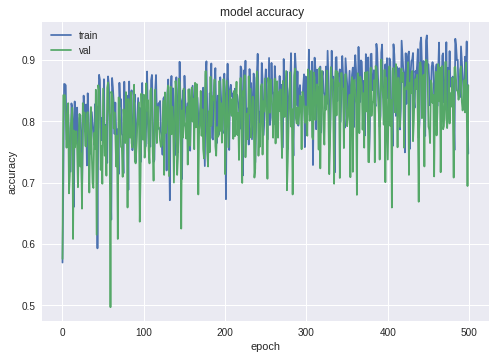

In [0]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'] )
plt.plot(history.history['val_categorical_accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

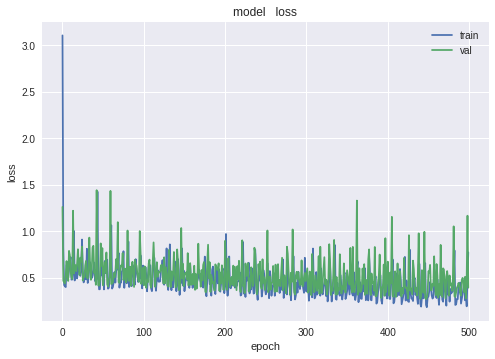

In [0]:
# summarize history for loss
plt.plot(history.history['loss'] )

plt.plot(history.history['val_loss'])
plt.title('model   loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()